In [ ]:
import sqlite3
import datetime
import time
from random import random, gauss
con = sqlite3.connect(':memory:', detect_types = sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)
con.execute('create table tp_cmd (ts timestamp, str_cmd text)')

now = datetime.datetime.now()
str_cmd = 'connect'

with con:
    c = con.cursor()
    c.execute('insert into tp_cmd(ts, str_cmd) values (?, ?)', (now, str_cmd))
    c.execute('select ts, str_cmd from tp_cmd')

row = c.fetchone()
x = 0

while x < 5:
    time.sleep(5)
    str_cmd = input()
    with con:
        c = con.cursor()
        c.execute('UDPATE tp_cmd SET ts = {0}, str_cmd = {1}'.format(datetime.datetime.now(), str_cmd))
    x += 1


In [25]:
data = {}
for i in range(1,36):
    data[f"data_{i}"] = {}
    for j in range(16):
        for k in range(24):
             data[f"data_{i}"][f"{chr(65+j)}{k+1}"] = gauss(2,0.75)
        
data

{'data_1': {'A1': 1.7799155167386902,
  'A2': 1.9587520316333402,
  'A3': 2.0880470462390033,
  'A4': 0.7710866155163714,
  'A5': 1.5228356638248712,
  'A6': 2.3708110467168457,
  'A7': 2.0527071091241735,
  'A8': 3.4330506837771786,
  'A9': 1.6882148597401236,
  'A10': 1.5217554764980203,
  'A11': 3.3608540679256986,
  'A12': 2.4348506491974304,
  'A13': 1.7457704774880403,
  'A14': 3.345584284346061,
  'A15': 2.4946920937844546,
  'A16': 2.3491470330559037,
  'A17': 2.799065023232309,
  'A18': 1.2118081023899143,
  'A19': 2.989036081973899,
  'A20': 2.3171287232102173,
  'A21': 1.8621407042417575,
  'A22': 2.7348909883808448,
  'A23': 1.9082109444401187,
  'A24': 0.5426886775973501,
  'B1': 2.110878899529652,
  'B2': 2.8934646144211285,
  'B3': 2.7437087124715083,
  'B4': 3.070339653218775,
  'B5': 2.1557755319810976,
  'B6': 1.3516628377226012,
  'B7': 1.717746249495343,
  'B8': 1.9614236359872448,
  'B9': 2.2396488499531166,
  'B10': 1.820101764276662,
  'B11': 1.3118723103728187,


In [26]:
[(k,v) for k,v in data['data_1'].items() if v < 0.65]

[('A24', 0.5426886775973501),
 ('B20', 0.6208243557135242),
 ('C6', 0.12707357528222984),
 ('C23', 0.586535977514351),
 ('D18', 0.6492923452255108),
 ('E13', 0.4796314791926086),
 ('G11', 0.3914857779669396),
 ('G23', 0.25481167212235256),
 ('I14', 0.04722658685325554),
 ('I23', -0.013916264734558315),
 ('J4', -0.1278665230098004),
 ('M1', 0.4630069841254334),
 ('M21', 0.08526650246447165),
 ('M23', 0.6386628102578509),
 ('N4', 0.5167677572190033),
 ('O18', 0.567453556908585),
 ('P7', 0.3831388533051059),
 ('P19', 0.4029876954968312)]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import os
import numpy as np
from functools import partial

In [91]:
first_two_colm_blank = 'dirty_tip_1.txt'
whole_plt_blank = 'WATER_BLANK.txt'
wd = '/Users/spencertrinh/Downloads/data/'
output_dir = f"{wd}output_v1.2"

def format_df(file_name):
    dfm = pd.read_csv(f'{wd}{file_name}',encoding='utf-16',sep='\t',skiprows=2,skipfooter=2,engine='python')
    dfm = dfm.set_index("Wavelength").drop("Temperature(¡C)",1)
    dfm.drop(dfm.columns[len(dfm.columns)-1],axis=1, inplace=True) 
    return dfm

dfm_part = format_df(first_two_colm_blank)
dfm_whole = format_df(whole_plt_blank)

In [92]:
wv_thres = 300
wv_range = range(200,810,10)
exclude_uvc_rows = sum(x < wv_thres for x in wv_range)
#percent_gt_thres = 0.02
#count_gt_vals = round(percent_gt_thres*len(wv_range))
num_of_std = 4 

In [5]:
exclude_uvc_rows

10

In [6]:
wellIds=[]
first_two_colms=[]
for i in range(1,17):
    for j in range(1,25):
        wellIds.append(f'{chr(64+i)}{j}' )
for w in wellIds:
    if w[1:] == '1' or w[1:] == '2':
        first_two_colms.append(w)

In [8]:
#partial (two colms)
blank_dfm_part = dfm_part.copy()[first_two_colms]
blank_dfm_part.set_index([pd.Index(range(200,810,10))])
blank_dfm_part['blank_mu'] = blank_dfm_part.apply(lambda x : abs(x)).mean(axis=1)
blank_dfm_part['blank_stdev'] = blank_dfm_part.apply(lambda x : abs(x)).std(axis=1) 
blank_dfm_part['mu_x_std'] = blank_dfm_part['blank_mu'] + num_of_std*blank_dfm_part['blank_stdev']

# whole plate
blank_dfm_whole = dfm_whole.copy()
blank_dfm_whole.set_index([pd.Index(range(200,810,10))])
blank_dfm_whole['blank_mu'] = blank_dfm_whole.mean(axis=1)

In [71]:
blank_dfm_part['mu_x_std'].std()*num_of_std

0.10501611043431387

In [11]:
blank_dfm_whole['blank_mu']

Wavelength
200    3.338617
210    3.208504
220    3.137271
230    3.470702
240    3.209785
250    3.121068
260    3.063164
270    2.829763
280    2.540843
290    0.937896
300    0.315630
310    0.197998
320    0.157957
330    0.126212
340    0.096048
350    0.083328
360    0.072879
370    0.058308
380    0.045010
390    0.040366
400    0.038932
410    0.038031
420    0.037373
430    0.036812
440    0.036486
450    0.036129
460    0.035741
470    0.035546
480    0.035405
490    0.035276
         ...   
510    0.035255
520    0.035210
530    0.035566
540    0.035352
550    0.035435
560    0.035399
570    0.035416
580    0.035318
590    0.035341
600    0.035424
610    0.035265
620    0.034885
630    0.034539
640    0.034151
650    0.034021
660    0.033783
670    0.033553
680    0.033346
690    0.033408
700    0.033263
710    0.033437
720    0.033711
730    0.034450
740    0.035116
750    0.035225
760    0.035201
770    0.034891
780    0.034611
790    0.034369
800    0.034255
Name: blank_m

In [89]:
def plot_plate(file_name, file_type = 'png', testing=True):
    if not testing:
        print(f"{os.getpid()} - {multiprocessing.current_process().name}: {file_name}")
    dfm = pd.read_csv(f"{wd}{file_name}",encoding='utf-16',sep='\t',skiprows=2,skipfooter=2,engine='python')
    dfm = dfm.set_index("Wavelength").drop("Temperature(¡C)",1)
    dfm.drop(dfm.columns[len(dfm.columns)-1],axis=1, inplace=True) 
    tmp_dfm = pd.DataFrame(index=dfm.index) 
    tmp_dfm = tmp_dfm.fillna(0)
    fig, ax = plt.subplots(16,24,figsize=(20,20))
    fig.subplots_adjust(wspace=0,hspace=0)
    cnt=0
    for i in range(16):
        for j in range(24):
            if dfm.values.max() > 2.5: # must subtract the whole plate blank (large initial peak) else, the two colm blank
                #dfm[f'{wellIds[cnt]}_blank_sub'] = [raw - blank for (raw, blank) in zip(dfm[f'{wellIds[cnt]}'],blank_dfm_whole['blank_mu'])]
                dfm[f'{wellIds[cnt]}_blank_sub'] = colm_blank_sub(dfm, f'{wellIds[cnt]}', blank_dfm_whole)
            else:
                #dfm[f'{wellIds[cnt]}_blank_sub'] = [raw - blank for (raw, blank) in zip(dfm[f'{wellIds[cnt]}'],blank_dfm_part['blank_mu'])]
                dfm[f'{wellIds[cnt]}_blank_sub'] = colm_blank_sub(dfm, f'{wellIds[cnt]}', blank_dfm_part)
            # if the baseline is high 
            if dfm[f'{wellIds[cnt]}_blank_sub'].values[exclude_uvc_rows:].mean() > 0.01:
                    # estimate the derivative using the limit definition  (y2-y1)/(x2-x1)
                    curve = estm_deriv(dfm[f'{wellIds[cnt]}_blank_sub'])
                    # find the median of the derivative values (the start of it plateauing)
                    deriv_med = np.median(curve)
                    # get index of the median value
                    idx_deriv_med = np.where(curve==deriv_med)[0][0] 
                    # index the data and calculate the mean to subtract  
                    yc_mu = dfm[f'{wellIds[cnt]}_blank_sub'].values[range(idx_deriv_med,len(dfm[f'{wellIds[cnt]}']))].mean()
                    # subtract the average to do baseline subtraction & overwrite data (only for plotting)
                    dfm[f'{wellIds[cnt]}_blank_sub'] = [val - yc_mu for val in dfm[f'{wellIds[cnt]}_blank_sub']]
                    #dfm[f'{wellIds[cnt]}_blank_sub'] = [raw - blank  for (raw, blank) in zip(dfm[f'{wellIds[cnt]}'],blank_dfm_part['blank_mu'])]
            ax[i,j].plot(dfm.index,
                             # blank subtraction from the average of each wavelength
                         dfm[f'{wellIds[cnt]}_blank_sub'])
            ax[i,j].set_title(f'{wellIds[cnt]}', fontsize=10)
            ax[i,j].title.set_position([.5, .725])
            ax[i,j].set_ylim([dfm.values.min() - 0.1, dfm.values.max() + 0.1])
            ax[i,j].tick_params(
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                left=False,         # ticks along the top edge are off
                labelbottom=False,
                labelleft=False)
            
            # extract each well data (baseline_sub) 
            tmp_dfm[f'{wellIds[cnt]}'] = dfm[f'{wellIds[cnt]}_blank_sub']
            # determine if the absolute value of each well data is larger than the threshold value 
            tmp_dfm[f'{wellIds[cnt]}_gt_Xstd'] = tmp_dfm[f'{wellIds[cnt]}'].iloc[exclude_uvc_rows:] > blank_dfm_part['mu_x_std'].iloc[exclude_uvc_rows:]
            
            #if sum(tmp_dfm[f'{wellIds[cnt]}_gt_Xstd'].fillna(0)) > count_gt_vals: and int(wellIds[cnt][1:]) > 2:
            # if there are any abs values greater than the average water blank 
            if any(tmp_dfm[f'{wellIds[cnt]}_gt_Xstd'].fillna(0)): 
                ax[i,j].set_facecolor('#ffe6e6')
            cnt+=1
    
    if not testing:
        fig.savefig(f"{output_dir}/plot_{file_name.replace('.txt','')}.{file_type}", format=f'{file_type}', dpi=900, quality=95)
    elif testing:
        return tmp_dfm

In [87]:
def colm_blank_sub(dfm, well_id, dfm_blank):
    dfm[well_id] = [raw - blank for (raw, blank) in zip(dfm[well_id],dfm_blank['blank_mu'])]
    return dfm[well_id]

In [15]:
def estm_deriv(data_values):
    x = data_values.index
    y = data_values.values
    return_list = []
    for i in range(len(data_values)):
        if i == 0:
            return_list.append((y[1] - y[0])/(x[1] - x[0]))
        elif i == len(data_values)-1:
            return_list.append((y[-1] - y[-2])/(x[-1] - x[-2]))
        else:
            return_list.append((y[i+1] - y[i-1])/(x[i+1] - x[i-1]))
    return np.array(return_list)

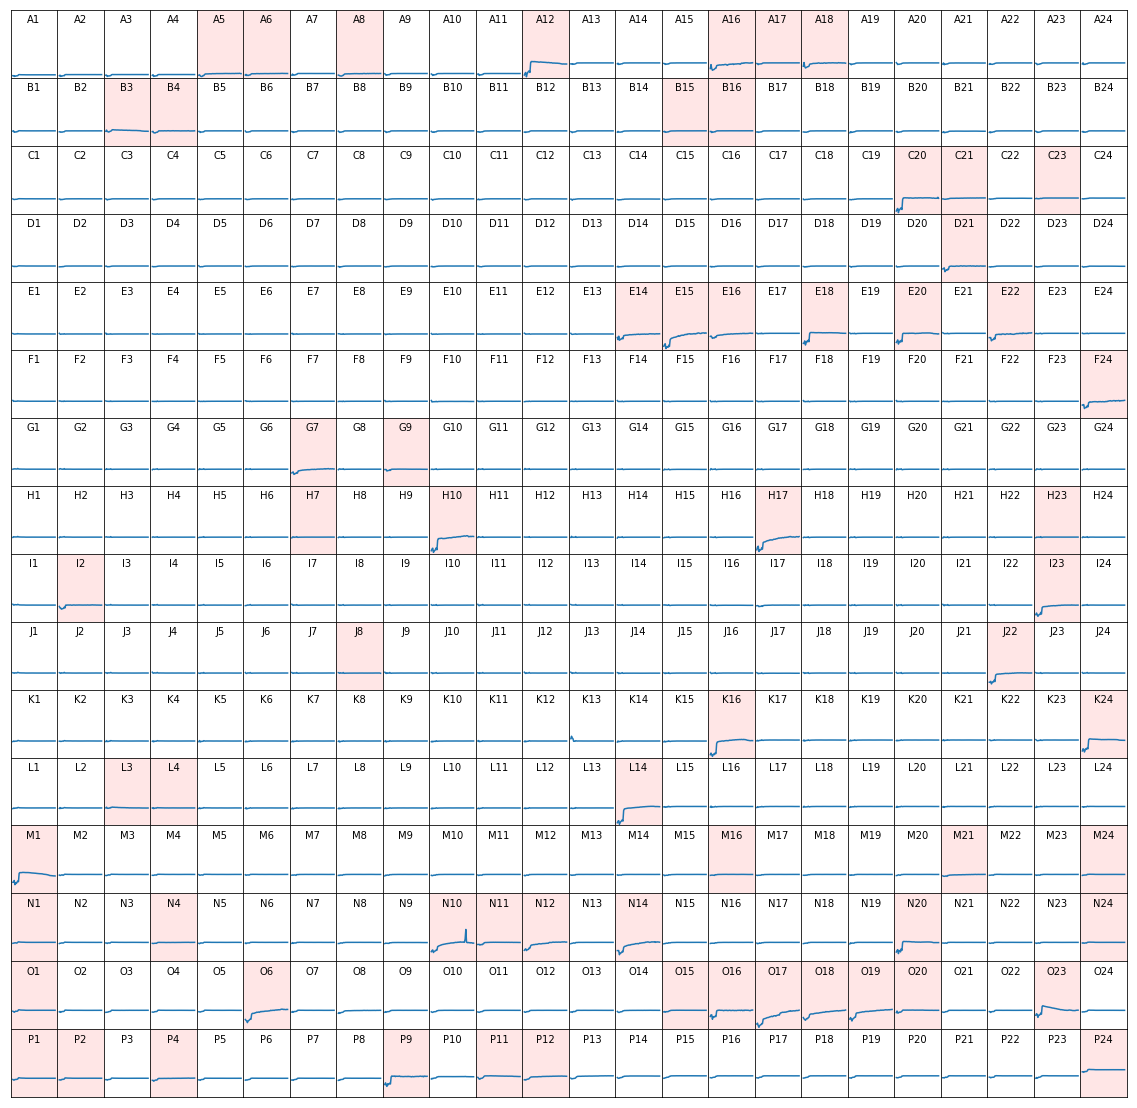

In [90]:
p = plot_plate('DYE_TEST1_CLEAN1.txt')

In [20]:
p['A1_gt_Xstd'][p['A1_gt_Xstd']==True]

Wavelength
300    True
310    True
320    True
330    True
340    True
350    True
360    True
370    True
380    True
Name: A1_gt_Xstd, dtype: object

In [34]:
pd.DataFrame([p['O15'][:exclude_uvc_rows+5], blank_dfm['blank_mu'][:exclude_uvc_rows+5]]).transpose()

,O15,blank_mu
Wavelength,,
200,3.068956,0.051665
210,2.969519,0.048283
220,2.858892,0.041097
230,3.234299,0.034743
240,2.993227,0.034379
250,2.897573,0.035706
260,2.849192,0.032847
270,2.639442,0.035022
280,2.439918,0.013084


In [93]:
file_list_args = []
for fi in os.listdir(wd):
    if fi.endswith('.txt'):
        file_list_args.append(fi)
        
def parallel_runs():
    with multiprocessing.Pool() as pool:
        try:
            partial_plot_plate = partial(plot_plate, testing=False, file_type='png') # plot_plate has only one argument file_name (testing is fixed to False)
            pool.map(partial_plot_plate, file_list_args)
            
        except RuntimeError as e:
            print(f'Error occured for Pool process: {os.getpid()} - {multiprocessing.current_process().name} -> {str(e)}')

In [94]:
parallel_runs()

674 - ForkPoolWorker-2: DYE_TEST2_DIRTY1.txt
676 - ForkPoolWorker-4: DYE_TEST1_DIRTY2.txt
675 - ForkPoolWorker-3: clean_3.txt
673 - ForkPoolWorker-1: WATER_BLANK.txt
676 - ForkPoolWorker-4: clean_2.txt
673 - ForkPoolWorker-1: DYE_TEST2_DIRTY2.txt
674 - ForkPoolWorker-2: DYE_TEST1_CLEAN1.txt
675 - ForkPoolWorker-3: DYE_QC_TEST2_BROMOPH.txt
676 - ForkPoolWorker-4: DYE_TEST1_CLEAN2.txt
675 - ForkPoolWorker-3: clean_1.txt
674 - ForkPoolWorker-2: dirty_tip_1.txt
673 - ForkPoolWorker-1: sonicate_1.txt
676 - ForkPoolWorker-4: DYE_TEST1_DIRTY1.txt
674 - ForkPoolWorker-2: sonicate_3.txt
675 - ForkPoolWorker-3: sonicate_2.txt
673 - ForkPoolWorker-1: dirty_tip_2.txt
676 - ForkPoolWorker-4: dirty_tip_3.txt
673 - ForkPoolWorker-1: sonicate_n_clean_3.txt
674 - ForkPoolWorker-2: sonicate_n_clean_1.txt
676 - ForkPoolWorker-4: DYE_QC_TEST1_ORANGE.txt
673 - ForkPoolWorker-1: sonicate_n_clean_2.txt


In [ ]:
for fi in file_list_args:
    plot_plate(fi, testing=False)

In [23]:
def plot_one(dfm, well_id):
    fig = plt.figure(figsize=(8, 8))
    axis = fig.add_subplot(1,1,1)
    axis.plot(dfm.index,dfm[well_id])
    axis.set_ylim([dfm.values.min() - 0.1, dfm.values.max() + 0.1])
    plt.show()

In [84]:
file_name = 'DYE_TEST1_CLEAN1.txt'
dfm = format_df(file_name)

In [74]:
#df = pd.DataFrame(index = range(200,810,10))
for i in range(16):
    for j in range(24):
        df[f'{chr(65+i)}{j+1}'] = colm_blank_sub(df,f'{chr(65+i)}{j+1}',blank_dfm_part)
        

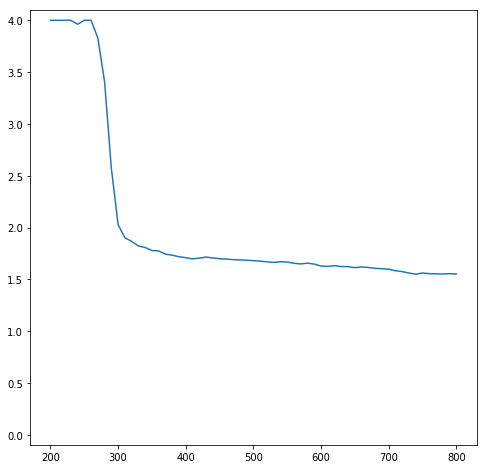

In [85]:
plot_one(dfm,'A12')

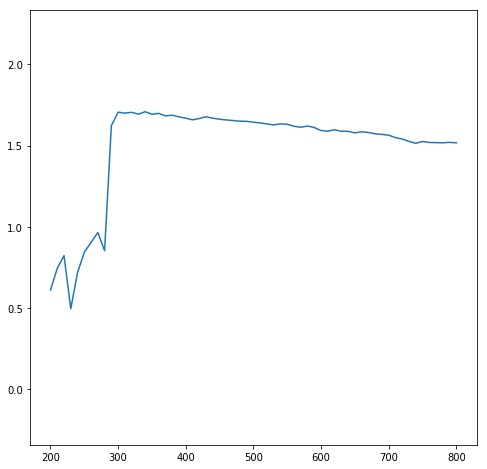

In [82]:
plot_one(df, 'A12')

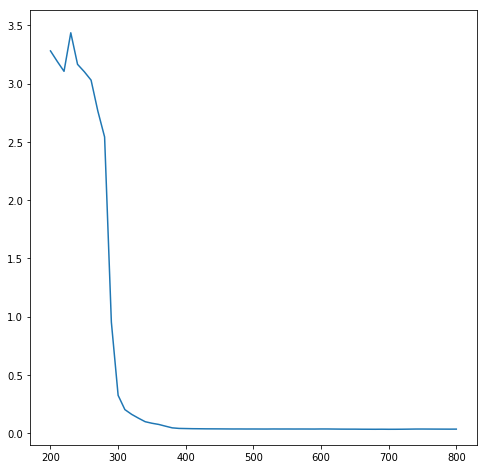

In [81]:
plot_one(blank_dfm_whole,'A12')

In [179]:
for i in range(16):
    print(f"{chr(65+i)}2 : {dfm1[f'{chr(65+i)}2'].iloc[exclude_uvc_rows:].values.mean()}")

A2 : -0.20075428921568625
B2 : -0.20387389705882353
C2 : -0.2025699754901961
D2 : -0.20276409313725488
E2 : -0.203977818627451
F2 : 0.692435906862745
G2 : -0.20206605392156865
H2 : -0.2027797794117647
I2 : -0.20091115196078435
J2 : -0.20148566176470586
K2 : -0.2022974264705882
L2 : -0.2038091911764706
M2 : 0.8889810049019607
N2 : -0.20502291666666667
O2 : -0.20160526960784317
P2 : 1.5083339460784317


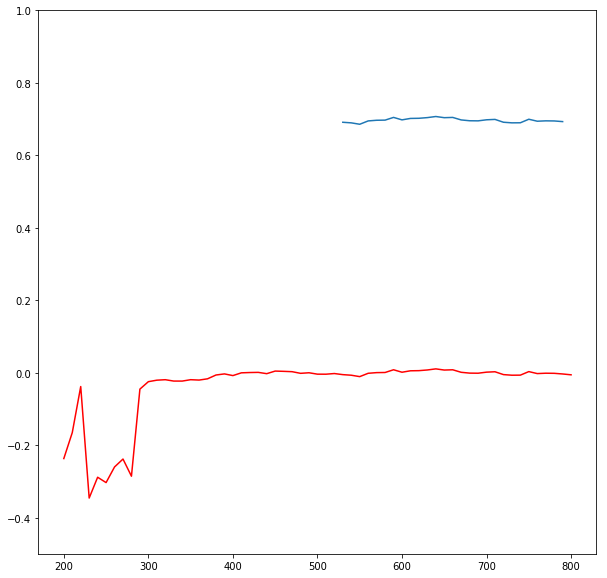

In [116]:
c = np.poly1d(dfm['F2'].values)


fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1,1,1)

xc = dfm.index.values[np.where(a<mu)]
#yc = c(xc)
yc = dfm['F2'].values[np.where(a<mu)]
axis.plot( xc, yc)
axis.set_ylim([-0.5,1])
yc_mu = yc.mean()
yc2 = [x - yc_mu for x in dfm['F2']]
axis.plot(dfm.index, yc2, color='red')